In [1]:
import re
import pandas as pd
from datetime import datetime
import torch
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import openpyxl

/Users/sadettin/Pythons/bertopic/bertopic_env/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
tweets = pd.read_csv("tidy_bsky.csv", encoding='utf-8')
#tweets_pos= tweets[tweets["sentr_durum"] == "positive"]
#tweets_pos
tweets

,id,date,name,username,text,url,referenced_post_id,referenced_username,referenced_post_type,referenced_post_url,...,pos,neu,neg,but_count,durum,element_id,word_count,sd,ave_sentiment,sentr_durum
0,3kh2aswiel22p,2023-12-21T00:00:00Z,ePrint Updates,eprint.bsky.social,Applications of Neural Network-Based AI in Cry...,https://bsky.app/profile/eprint.bsky.social/po...,NaN,NaN,NaN,NaN,...,0.000,1.000,0.000,0,neutral,1,14,NaN,0.000000,neutral
1,3kfptczu2y427,2023-12-04T00:00:00Z,Pulse,pulse.bsky.social,AI takes center stage at COP28 as experts deba...,https://bsky.app/profile/pulse.bsky.social/pos...,NaN,NaN,NaN,NaN,...,0.185,0.745,0.070,0,positive,2,23,NaN,0.000000,neutral
2,3kfprcmi4c72a,2023-12-04T00:00:00Z,Pulse,pulse.bsky.social,Behind the Curtain: The U.S. is not ready for ...,https://bsky.app/profile/pulse.bsky.social/pos...,NaN,NaN,NaN,NaN,...,0.139,0.596,0.265,0,negative,3,28,NaN,-0.340168,negative
3,3kfkywgni2t2l,2023-12-02T00:00:00Z,Pulse,pulse.bsky.social,Europe’s AI crackdown looks doomed to be felle...,https://bsky.app/profile/pulse.bsky.social/pos...,NaN,NaN,NaN,NaN,...,0.158,0.550,0.292,0,negative,4,30,NaN,-0.082158,negative
4,3kfan64zdsw22,2023-11-28T00:00:00Z,Pulse,pulse.bsky.social,The US is racing ahead in its bid to control a...,https://bsky.app/profile/pulse.bsky.social/pos...,NaN,NaN,NaN,NaN,...,0.322,0.612,0.066,0,positive,5,27,NaN,0.298298,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31776,3l5ityhqwmb2f,2024-10-02T04:01:08Z,arxiv cs.CR,arxiv-cs-cr.bsky.social,Junjun Huang\r\nArtificial intelligence-based ...,https://bsky.app/profile/arxiv-cs-cr.bsky.soci...,NaN,NaN,NaN,NaN,...,0.000,1.000,0.000,0,neutral,31916,14,NaN,0.133631,positive
31777,3l5irhfee5k2y,2024-10-02T03:15:46Z,"jokitugas1234 di twitter, 1740+ testi di likes",trusted.bsky.social,Testi 1264 - Mata Kuliah Artificial Intelligen...,https://bsky.app/profile/trusted.bsky.social/p...,NaN,NaN,NaN,NaN,...,0.258,0.742,0.000,0,positive,31917,19,NaN,0.229416,positive
31778,3l5ion3ehsc2g,2024-10-02T02:25:17Z,Republika.co.id,republika-poster.bsky.social,Penerapan Artificial Intelligence dalam Bidang...,https://bsky.app/profile/republika-poster.bsky...,NaN,NaN,NaN,NaN,...,0.307,0.693,0.000,0,positive,31918,19,NaN,0.229416,positive
31779,3l5ijddhl3q2r,2024-10-02T00:50:21Z,Rocky Mountain Politics,rockymntnpols.bsky.social,"""California Governor Gavin Newsom vetoed a lan...",https://bsky.app/profile/rockymntnpols.bsky.so...,NaN,NaN,NaN,NaN,...,0.286,0.714,0.000,0,positive,31919,24,0.228535,0.176364,positive


In [4]:
# Filter negative
tweets = tweets.dropna(subset=['text'])
tweets.text = tweets.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
tweets.text = tweets.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
tweets.text = tweets.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.text).split()), 1)
tweets = tweets.loc[tweets.text != "", :]

#timestamps = uk_us.date1.to_list()
timestamps = tweets.tarih.to_list()
tweets2 = tweets.text.to_list()


In [5]:
# Prepare embeddings
custom_stopwords = ["generative","artificial","intelligence","ai","artificialintelligence","pelvis","naked"]
all_stopwords = list(ENGLISH_STOP_WORDS) + custom_stopwords

# Initialize the CountVectorizer with the combined stopwords
vectorizer_model = CountVectorizer(stop_words=all_stopwords)
sentence_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
embeddings = sentence_model.encode(tweets2, show_progress_bar=False)


In [6]:
# Train BERTopic
topic_model = BERTopic(min_topic_size=100,
                        vectorizer_model=vectorizer_model,
                       verbose= True).fit(tweets2, embeddings)

2025-01-14 22:18:43,253 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-01-14 22:18:53,377 - BERTopic - Dimensionality - Completed ✓
2025-01-14 22:18:53,378 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
h

In [15]:
topic_model.get_topic(39)

[('meta', 0.19390637243538808),
 ('facebook', 0.07510573506788706),
 ('instagram', 0.06999426377372454),
 ('platforms', 0.04893549245216662),
 ('social', 0.04684962639619765),
 ('users', 0.0346944451904691),
 ('metaverse', 0.03366879378279819),
 ('media', 0.03289070623881677),
 ('influencer', 0.0325832492442371),
 ('glasses', 0.03077616787778288)]

In [25]:
freq=topic_model.get_topic_info()
# Save as XLSX
freq.to_excel('bsky_topic_frequency.xlsx', index=False)
freq

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,13559,-1_com_www_new_technology,-1_com_www_new_technology,"[com, www, new, technology, tech, human, learn...",[microsoft designer is a graphic design app us...
1,0,1666,0_health_healthcare_care_cancer,Healthcare,"[health, healthcare, care, cancer, medical, me...",[this viewpoint provides recommendations for h...
2,1,1062,1_energy_climate_power_nuclear,Climate & Energy,"[energy, climate, power, nuclear, data, center...",[microsoft is hiring a nuclear energy expert t...
3,2,922,2_jobs_job_workers_business,2_jobs_job_workers_business,"[jobs, job, workers, business, work, businesse...",[artificial intelligence ai has the potential ...
4,3,900,3_stupidity_natural_term_like,Business & Jobs,"[stupidity, natural, term, like, intelligent, ...",[we don t need artificial intelligence when we...
5,4,794,4_biden_order_executive_house,US Policy,"[biden, order, executive, house, fedscoop, sta...",[fact sheet president biden issues executive o...
6,5,723,5_art_artist_image_artists,Generative Art,"[art, artist, image, artists, images, aiart, a...",[generative artificial intelligence human crea...
7,6,638,6_thank_thanks_oh_yeah,6_thank_thanks_oh_yeah,"[thank, thanks, oh, yeah, fuck, good, congratu...","[oh hell yeah, oh hell yeah congratulations, o..."
8,7,571,7_openai_altman_sam_chatgpt,OpenAI & ChatGPT,"[openai, altman, sam, chatgpt, model, ceo, com...",[sam altman the ousted ceo of chatgpt creator ...
9,8,514,8_stock_stocks_stockmarket_nasdaq,Stocks,"[stock, stocks, stockmarket, nasdaq, nvidia, b...",[motley fool nvidia super micro or broadcom me...


In [24]:
#changing labels
topic_model.set_topic_labels({0:"Healthcare",
                              1:"Climate & Energy",
                              3:"Business & Jobs",
                              4:"US Policy",
                              5:"Generative Art ",
                              7:"OpenAI & ChatGPT",
                              8:"Stocks",
                              9:"Education & Learning",
                             10:"Election Disinformation",
                             11:"China Policy",
                             12:"EU AI Acts",
                             13:"Copyrights",
                             14:"Hollywood & Movies",
                             15:"Copyright",
                             16:"Ukraine Defense",
                             18:"Music & Spotify",
                             19:"Elon Musk", 
                             20:"Elon Musk",
                   
                             21:"Media & Journalism",
                             22:"Apple & İphone Features",
                             24:"Court & Law",
                             25:"Writing Publishing",
                             27:"Amazon & Anthropic",
                             29:"AI Startups & Funding",
                             30:"Nvidia Chips",
                             33:"Cybersecurity",
                             34:"Crypto & Blockchain",
                             40:"Scammers & Phishing",
                             42:"Bias & Racism",
                             43:"Israel-Hamas War",
                             45:"Child Abuse",
                             47:"Microsoft AI"})

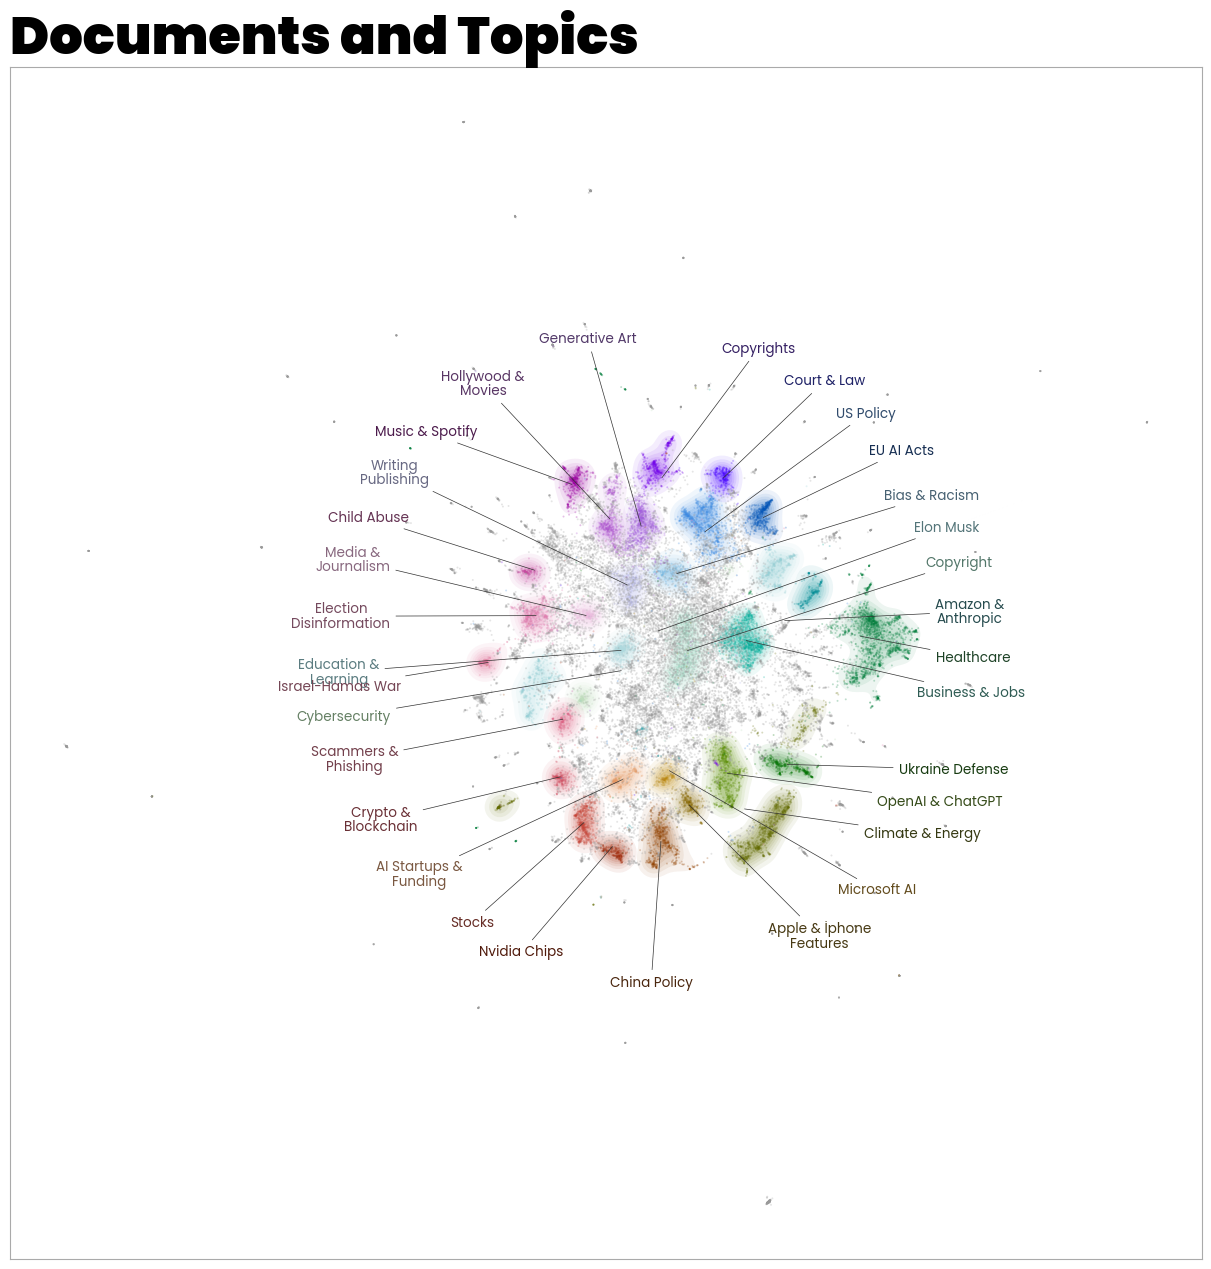

In [26]:
# with the original embeddings
# with the original embeddings
fig0=topic_model.visualize_document_datamap(tweets2, embeddings=embeddings,
                                            custom_labels =True,
                                            font_family="Poppins",
                                            max_font_size=40,
                                            min_font_size=10,
                                            point_size=2,
                topics =[0,1,3,4,5,7,8,9,10,11,12,13,14,15,16,18,19,20,21,22,24,25,27,29,30,33,34,40,42,43,45,47])

In [28]:

fig0.savefig("file_bsky.pdf")
fig0.savefig("file_bsky.svg")

In [35]:
?topic_model.visualize_document_datamap

Signature:
topic_model.visualize_document_datamap(
    docs: List[str],
    topics: List[int] = None,
    embeddings: numpy.ndarray = None,
    reduced_embeddings: numpy.ndarray = None,
    custom_labels: Union[bool, str] = False,
    title: str = 'Documents and Topics',
    sub_title: Optional[str] = None,
    width: int = 1200,
    height: int = 1200,
    **datamap_kwds,
)
Docstring:
Visualize documents and their topics in 2D as a static plot for publication using
DataMapPlot. This works best if there are between 5 and 60 topics. It is therefore best
to use a sufficiently large `min_topic_size` or set `nr_topics` when building the model.

Arguments:
    topic_model:  A fitted BERTopic instance.
    docs: The documents you used when calling either `fit` or `fit_transform`
    embeddings:  The embeddings of all documents in `docs`.
    reduced_embeddings:  The 2D reduced embeddings of all documents in `docs`.
    custom_labels:  If bool, whether to use custom topic labels that were def